In [1]:
%pylab inline
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from tqdm import trange
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [2]:
min_speed, max_speed, nb_speed_brackets = 0.0, 200.0, 20
speed_bracket_size = (max_speed - min_speed) / nb_speed_brackets

def mph_to_kph(mph):
    return mph / 0.621371

def get_speed_label(speed_mph):
    speed_kph = mph_to_kph(speed_mph)
    if speed_kph >= max_speed:
        speed_kph = max_speed - 1
    elif speed_kph < min_speed:
        speed_kph = min_speed
    return (int) ((speed_kph - min_speed) / speed_bracket_size)

def get_speed_from_label(speed_label):
    if speed_label < 0 or speed_label > nb_speed_brackets:
        return 0
    return min_speed + speed_bracket_size * speed_label

def load_dataset(ds_filepath, test=False):
    train_labels = None
    with np.load(ds_filepath, mmap_mode=None) as dataset:
        train_images, train_labels = dataset['train_images'], dataset['train_labels']
    # Create speed brackets where each bracket corresponds with a label.
    print('Min Speed={}, Max Speed={}'.format(mph_to_kph(train_labels.min()), mph_to_kph(train_labels.max())))
    train_labels = np.vectorize(lambda x: mph_to_kph(x))(train_labels)
    train_images = train_images.reshape(-1, 96, 128, 3)
    print('Train dataset: image_shape={}, labels_shape={}'.format(train_images.shape, train_labels.shape))

    train_images = train_images[:,:,:,0] * 0.2989 + train_images[:,:,:,1]  * 0.5870  + train_images[:,:,:,2] * 0.1140
    print(train_images.shape)
    return train_images, train_labels

In [4]:
train_images, train_labels = load_dataset('data\\train_dataset_15000_20400.npz')


train_labels_mod = np.vectorize(lambda x: get_speed_label(x))(train_labels)
train_labels_mod.min(), train_labels_mod.max()

Min Speed=0.0, Max Speed=23.963409943495915
Train dataset: image_shape=(5400, 96, 128, 3), labels_shape=(5400,)
(5400, 96, 128)


(0, 3)

In [5]:
def one_hot_encode(x, n_classes):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
     """
    #return torch.tensor(np.eye(n_classes)[x])
    return torch.eye(n_classes)[(int)(x[0])]

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
BATCH_SIZE, D_in, H, D_out = 4, 36864, 100, 32

class SpeedNet(nn.Module):
    def __init__(self):
        super(SpeedNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(182528, 128) # max pooling is applied before the fully-connected layers
        self.fc2 = nn.Linear(128, nb_speed_brackets)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        return self.fc2(x)

class CarNet(nn.Module):
    def __init__(self):
        super(CarNet, self).__init__()
        self.speed_net = SpeedNet()

#         self.lstm_model = nn.LSTM(input_size=D_out, hidden_size=nb_speed_brackets, num_layers=1, batch_first=True)
#         self.fc = nn.Linear(D_out, 1)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        batch_size, C, H, W = x.size()

        x_out = self.speed_net(x)
#         lstm_input = x_out.view(batch_size, 1, D_out)
        
#         lstm_output, hidden = self.lstm_model(lstm_input)
#         return self.log_softmax(hidden[0][0])
        return self.log_softmax(x_out)
        #return self.fc(hidden[0][0])

    def predict(self, x):
        return self(x)

In [6]:
device = torch.device("cuda:0")
ftype = torch.cuda.FloatTensor
ltype = torch.cuda.LongTensor
torch.backends.cuda.matmul.allow_tf32 = False
torch.autograd.set_detect_anomaly(True)
model = CarNet()
model.to(device)
print(model)
loss_function = nn.NLLLoss(reduction='mean') #nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) #torch.optim.SGD(model.parameters(), lr=1e-4)

CarNet(
  (speed_net): SpeedNet(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (dropout1): Dropout(p=0.25, inplace=False)
    (dropout2): Dropout(p=0.5, inplace=False)
    (fc1): Linear(in_features=182528, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=20, bias=True)
  )
  (log_softmax): LogSoftmax(dim=1)
)


Loss 3.0081, Accuracy 0.0000: 100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


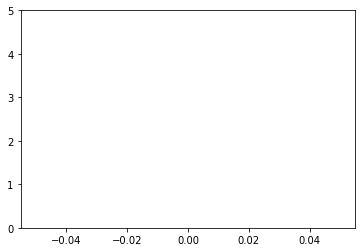

In [6]:
model.train()
losses = []
t = trange(1)
for i in t:
    sample = np.random.randint(0, train_images.shape[0], size=(BATCH_SIZE))
    X = torch.tensor(train_images[sample], device=device).type(ftype)
    Y = torch.tensor(train_labels_mod[sample], device=device).type(ltype)
    
    X = X[:,None,:,:]
    
    y_pred = model(X)

    # Compute and print loss
    loss = loss_function(y_pred, Y)
    accuracy = (y_pred.argmax(axis = 1) == Y).float().mean()
    t.set_description("Loss %.4f, Accuracy %.4f" % (loss.item(), 100.0 * accuracy))
    losses.append(loss.item())

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

#     torch.cuda.empty_cache()

plt.ylim(0.0, 5.0)
plt.plot(losses)

In [7]:
pretrained_model_path = 'data\\pretrained_model.tar'

In [78]:
model.train()
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'losses': losses,
            },
    pretrained_model_path)

In [8]:
checkpoint = torch.load(pretrained_model_path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
losses = checkpoint['losses']

model.eval()

CarNet(
  (speed_net): SpeedNet(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (dropout1): Dropout(p=0.25, inplace=False)
    (dropout2): Dropout(p=0.5, inplace=False)
    (fc1): Linear(in_features=182528, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=20, bias=True)
  )
  (log_softmax): LogSoftmax(dim=1)
)

Actual speed: 22.339228898677277, Predicted speed: tensor([30.], device='cuda:0')
Mean Squared Error Loss: 605.4793324599693


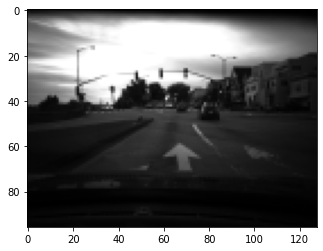

In [27]:
model.eval()
# device = torch.device('cpu')
# ftype = torch.FloatTensor
# ltype = torch.LongTensor
model.to(device)
test_image_index = 0
test_image = train_images[test_image_index]
actual_speed = train_labels[test_image_index]
pylab.imshow(test_image, cmap='gray')
test_tensor = torch.tensor(test_image[np.newaxis,np.newaxis,:,:], device=device).type(ftype)
predicted_speed =  model.predict(test_tensor)
print('Actual speed: {}, Predicted speed: {}'.format(actual_speed, get_speed_from_label(predicted_speed.argmax(axis=1))))

sample = np.random.randint(0, train_images.shape[0], size=(BATCH_SIZE))
X = torch.tensor(train_images[sample], device=device).type(ftype)
Y = torch.tensor(train_labels[sample], device=device).type(ftype).view(BATCH_SIZE, 1)
X = X[:,None,:,:]
Y_pred = model(X).argmax(axis=1).reshape(BATCH_SIZE, 1)
Y_pred = torch.tensor(np.vectorize(lambda x: get_speed_from_label(x))(Y_pred.detach().cpu().numpy()), device=device)
mse_loss = nn.MSELoss(reduction='mean')
print('Mean Squared Error Loss: {}'.format(mse_loss(Y_pred, Y).item()))

In [9]:
class SpeedNet2(nn.Module):
    def __init__(self):
        super(SpeedNet2, self).__init__()
        self.features = list(model.speed_net.children())[:-1]
        self.conv1 = self.features[0]
        self.conv2 = self.features[1]
        self.dropout1 = self.features[2]
        self.dropout2 = self.features[3]
        self.fc1 = self.features[4]

    def forward(self, x):
        batch_size, C, H, W = x.size()
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        return x

    def predict(self, x):
        return self(x)

class CarNet2(nn.Module):
    def __init__(self):
        super(CarNet2, self).__init__()
        self.features = SpeedNet2()
        self.embed = nn.Embedding(nb_speed_brackets, 8)
        self.lstm_model = nn.LSTM(input_size=8, hidden_size=64, num_layers=1, batch_first=True)
        self.fc = nn.Linear(64, nb_speed_brackets)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, image_features, speeds_refs):
        batch_size, C, H, W = image_features.size()
bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
        x_out = self.features(image_features)
        embeddings = self.embed(speeds_refs)
        lstm_input = torch.cat((x_out.unsqueeze(1), embeddings), 1)
        
        _, (hn, cn) = self.lstm_model(lstm_input)
        out = self.fc(hn)
        return self.log_softmax(out)

    def predict(self, x):
        return self(x)

In [10]:
BATCH_SIZE = 4
car_net_v2 = CarNet2()
car_net_v2.to(device)

CarNet2(
  (features): SpeedNet2(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (dropout1): Dropout(p=0.25, inplace=False)
    (dropout2): Dropout(p=0.5, inplace=False)
    (fc1): Linear(in_features=182528, out_features=128, bias=True)
  )
  (lstm_model): LSTM(20, 512)
  (fc): Linear(in_features=512, out_features=20, bias=True)
  (log_softmax): LogSoftmax(dim=1)
)

In [17]:
model.train()
car_net_v2.train()
loss_function =  nn.NLLLoss(reduction='mean') #nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(car_net_v2.parameters(), lr=1e-4)

BATCH_SIZE = 4
max_interval = 100
t = trange(max_interval)
for i in t:
    sample = np.arange(i, i + BATCH_SIZE)
    X = torch.tensor(train_images[sample], device=device).type(ftype)
    Y_one_hot_enc = np.apply_along_axis(lambda x: one_hot_encode(x, nb_speed_brackets), 1, train_labels_mod[sample].reshape(BATCH_SIZE, 1))
    Y_one_hot_enc = torch.tensor(Y_one_hot_enc, device=device).type(ftype)
    Y = torch.tensor(train_labels_mod[sample], device=device).reshape(BATCH_SIZE, 1).type(ltype)

    X = X[:,None,:,:]

    model_output = car_net_v2((X, Y_one_hot_enc))
    Y_pred = model_output.type(ftype)
    loss = loss_function(Y_pred, Y.reshape(BATCH_SIZE))
    t.set_description("Mean Squared Error Loss: %.4f" % (loss.item()))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Mean Squared Error Loss: 0.0137: 100%|██████████| 100/100 [00:06<00:00, 15.64it/s]


torch.Size([4, 1, 96, 128])
Actual speed: [22.3392289  22.33148956 22.39371165 22.39599531], Predicted speed: 30.0


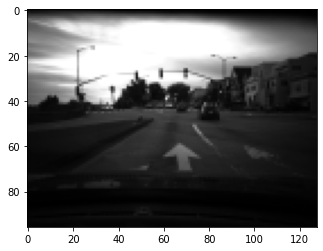

In [37]:
car_net_v2.eval()
test_image_index = sample = np.arange(0, 0 + BATCH_SIZE)
test_image = train_images[test_image_index]
actual_speed = train_labels[test_image_index]
pylab.imshow(test_image[0], cmap='gray')
test_tensor = torch.tensor(test_image[np.newaxis, :, :], device=device).type(ftype).reshape(BATCH_SIZE, 1, 96, -1)
Y_one_hot_enc = np.apply_along_axis(lambda x: one_hot_encode(x, nb_speed_brackets), 1, train_labels_mod[sample].reshape(BATCH_SIZE, 1))
Y_one_hot_enc = torch.tensor(Y_one_hot_enc, device=device).type(ftype)

print(test_tensor.shape)
predicted_speed =  car_net_v2.predict((test_tensor, Y_one_hot_enc))
print('Actual speed: {}, Predicted speed: {}'.format(actual_speed, get_speed_from_label(predicted_speed.argmax(dim=1)[0])))